In [75]:
import pandas as pd
import numpy as np
import tensorflow as tf

import os, sys
import json
from os import listdir
from os.path import isfile, join
import shutil 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from random import randrange
from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import scipy.io

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

In [76]:
tf.random.set_seed(42)
np.random.seed(42)

In [77]:
!nvidia-smi

Sun Dec 18 12:00:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |  14634MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [78]:
if tf.test.gpu_device_name():

  # GPU connected
  print('GPU Connected')

  # Use mixed_float16 only wheb there is a GPU
  tf.keras.mixed_precision.set_global_policy(policy="mixed_float16")

else:

  # No GPU connected
  print('No GPU Connected')

print(tf.keras.mixed_precision.global_policy())

GPU Connected
<Policy "mixed_float16">


In [79]:
is_download_cihp_dataset = False

# model with reduced classes and transfer learning
run_model_parsing_3 = False
run_model_parsing_4 = False

In [80]:
# saved_models_path = '/content/gdrive/MyDrive/Saved-Models'

# from google.colab import drive
# drive.mount('/content/gdrive')

saved_models_path = '/content'

In [81]:
def get_file_paths_at_index(root_dir, index=0):

  """
  get a list of datapoints at an index from each sub directory
  """
  
  if os.path.exists(root_dir):

    result_files = []
    for root, dirs, files in os.walk(root_dir):
        if files and len(files) > index:
            result_files.append(os.path.join(root, sorted(files)[index]))

    return sorted(result_files)

  else:
    print('No such directory found: ', root_dir)

In [82]:
def move_all_files_and_sub_dirs(source, destination):

  """
  Moves all files and sub-directories at root level of a directory to another place 
  along with all there contents
  """

  root_dir = list(os.walk(source))[0][0]
  sub_dir_and_files = [os.path.join(root_dir, i) for i in (list(os.walk(source))[0][1] + list(os.walk(source))[0][2])]

  for item in sub_dir_and_files:

    shutil.move(item, destination)

In [83]:
%%time
if is_download_cihp_dataset:

  !pip install --upgrade --no-cache-dir gdown

  !wget https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
  !gdown 1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

  !unzip -q /content/instance-level-human-parsing.zip -d CIHP

  # Remove ATR dataset as we do not need it
  shutil.rmtree('/content/CIHP/ICCV15_fashion_dataset(ATR)')

  # Move CIHP dataset folders from tree of sub-dirs to dir "/content/CIHP"
  move_all_files_and_sub_dirs('/content/CIHP/instance-level_human_parsing/instance-level_human_parsing', '/content/CIHP')

  # Remove empty directories from dataset
  shutil.rmtree('/content/CIHP/instance-level_human_parsing') 

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


In [84]:
def get_files_in_dir(dir_path):

  """
  Return a list of file names in a given directory
  """

  if os.path.exists(dir_path):
    files = sorted([f for f in listdir(dir_path) if isfile(join(dir_path, f))])
    return files

  else:
    print('No such directory found: ', dir_path)

In [85]:
def merge_two_list(list1, list2):
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

In [86]:
def shuffle_and_ratio_data(images, masks, image_root_path, mask_root_path, dataset_ratio=1):

  images_len = len(images)
  masks_len = len(masks)

  # make image and masks tuples, shuffle the data and then return given percentage of that data
  image_mask_tuples = merge_two_list(images, masks)
  shuffle(image_mask_tuples)
  image_mask_tuples_per = image_mask_tuples[:int(images_len * dataset_ratio)]

  images_result = [os.path.join(image_root_path, x[0]) for x in image_mask_tuples_per]
  masks_result = [os.path.join(mask_root_path, x[1]) for x in image_mask_tuples_per]

  return images_result, masks_result

In [87]:
def get_class_labels():

  # class labels
  # background was not mentioned in readme file but its color code was present in mat file at first index
  class_labels = [
      "Background", # 0
      "Hat", # 1
      "Hair", # 2
      "Glove", # 3
      "Sunglasses", # 4 
      "UpperClothes", # 5, shirt
      "Dress", # 6, wore by women like formal with short+pant
      "Coat", # 7
      "Socks", # 8
      "Pants", # 9
      "Torso-skin", # 10, means neck
      "Scarf", # 11
      "Skirt", # 12
      "Face", # 13
      "Left-arm", # 14
      "Right-arm", # 15
      "Left-leg", # 16
      "Right-leg", # 17
      "Left-shoe", # 18
      "Right-shoe", # 19
  ]

  return class_labels

In [88]:
class_labels = get_class_labels()
len(class_labels)

20

In [89]:
cihp_test_dir = '/content/CIHP/Testing'
cihp_train_dir = '/content/CIHP/Training'
cihp_valid_dir = '/content/CIHP/Validation'

In [90]:
images_train = get_files_in_dir(os.path.join(cihp_train_dir, 'Images'))
masks_train = get_files_in_dir(os.path.join(cihp_train_dir, 'Categories'))

images_valid = get_files_in_dir(os.path.join(cihp_valid_dir, 'Images'))
masks_valid = get_files_in_dir(os.path.join(cihp_valid_dir, 'Categories'))

images_test = get_files_in_dir(os.path.join(cihp_test_dir, 'Images'))

print(len(images_train), len(masks_train), len(images_valid), len(masks_valid), len(images_test))

28280 28280 5000 5000 5000


In [91]:
train_x, train_y = shuffle_and_ratio_data(images_train, masks_train, image_root_path='/content/CIHP/Training/Images', mask_root_path='/content/CIHP/Training/Category_ids', dataset_ratio=0.04)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False,)

valid_x, valid_y = shuffle_and_ratio_data(images_valid, masks_valid, image_root_path='/content/CIHP/Validation/Images', mask_root_path='/content/CIHP/Validation/Category_ids', dataset_ratio=0.04)

len(train_x), len(train_y), len(test_x), len(test_y), len(valid_x), len(valid_y)

(904, 904, 227, 227, 200, 200)

In [92]:
# ['Background', 'UpperClothes', 'Dress', 'Pants', 'Face', 'Left-arm', 'Left-leg']
# replace_array = [[[1, 2, 4, 10, 11], 13], [[3, 15], 14], [[7], 5], [[8, 17, 18, 19], 16], [[12], 9]]

replace_array = [[[1, 2, 4, 10, 11], 13], [[3, 15], 14], [[8, 17, 18, 19], 16], [[12], 9]]
replaced_indexes = np.concatenate([i for i, j in replace_array])

remaining_indexes = [i for i in  np.arange(20) if i not in replaced_indexes]

print(replaced_indexes)
print(remaining_indexes)

merged_class_labels = []
for i in range(len(class_labels)):
  if i not in replaced_indexes:
    merged_class_labels.append(class_labels[i])

print(merged_class_labels)
print(len(merged_class_labels))

def merge_classes(mask_image_array):

  """
  replace_array = [ [ [ replace_from ], replace_to] ]
  """

  # mask_original = cv2.imread(mask_path, cv2.COLOR_BGR2RGB)
  mask_merged = mask_image_array

  for i, j in replace_array:
    mask_merged = np.select([mask_merged == k for k in i], [j for _ in i], mask_merged)

  # after merging values are from 0-19 so we make them 0-6
  for i in remaining_indexes:
    mask_merged = np.select([mask_merged == i], [np.where(remaining_indexes == i)], mask_merged)

  return mask_merged

[ 1  2  4 10 11  3 15  8 17 18 19 12]
[0, 5, 6, 7, 9, 13, 14, 16]
['Background', 'UpperClothes', 'Dress', 'Coat', 'Pants', 'Face', 'Left-arm', 'Left-leg']
8


In [93]:
is_allow_merge = True

# IMG_HEIGHT = 400
# IMG_WIDTH = 480
IMG_HEIGHT = 320
IMG_WIDTH = 416

N_CHANNELS = 3

N_CLASSES = len(merged_class_labels) if is_allow_merge else len(class_labels)

BATCH_SIZE_PARSING = 32

print(N_CLASSES)

8


In [94]:
def process_image_and_mask(image_path, mask_path):

  image = cv2.imread(image_path)
  image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) # (W,H)
  image = image/255. 
  image = image.astype(np.float32)

  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) # (W,H)

  mask_orig = mask
  mask_processed = mask

  # This will merge unwanted mask classes
  if is_allow_merge:
    mask_processed = merge_classes(mask_image_array = mask)

  # mask normalization is different from simply /255, below we are doing mask normalization, it is one-hot encoding in our case
  mask_objects = []
  for gray_scale_value in range(N_CLASSES):
    # we are setting cmap (binary mask) values to true where ever the color maches the color on mask
    # in this way we will get 20 images each of which shows an object, for every mask image
    # and we are doing this for all pixels
    cmap = np.all(np.equal(np.expand_dims(mask_processed, axis=-1), gray_scale_value), axis=-1)
    mask_objects.append(cmap)

  # stack adds a new dimension to the array and stacks all images into a single array
  # it makes 20 images of (400, 480) into an array of (400, 480, 20)
  # (400, 480, 20) => this gives one-hot encoding where out of 20 items in the array any one is 1 which shows class value
  # we are doing this one-hot encoding thing beacuse this gives good results for training
  mask_stack = np.stack(mask_objects, axis=-1)
  mask_stack = mask_stack.astype(np.uint8)

  # print(mask_stack)

  return image, mask_orig, mask_processed, mask_stack

/content/CIHP/Validation/Images/0000870.jpg /content/CIHP/Validation/Category_ids/0000870.png
(320, 416, 8) (320, 416)


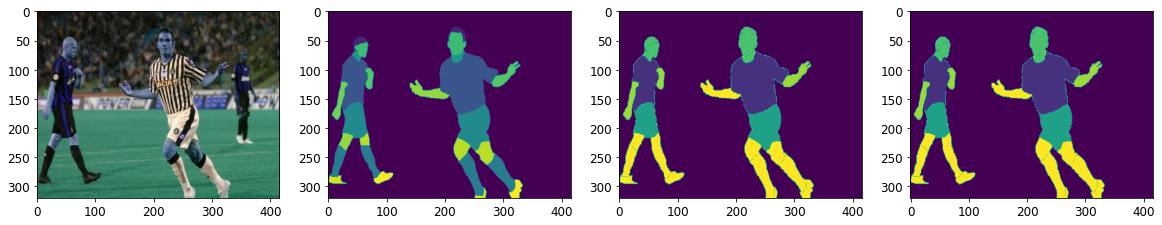

In [95]:
image_path = get_file_paths_at_index('/content/CIHP/Validation/Images', 75)[0]
mask_path = get_file_paths_at_index('/content/CIHP/Validation/Category_ids', 75)[0]

print(image_path, mask_path)

image, mask_orig, mask_processed, mask_stack = process_image_and_mask(image_path, mask_path)

fig = plt.figure(figsize=(20, 14))

fig.add_subplot(1, 4, 1)
plt.imshow(image)

fig.add_subplot(1, 4, 2)
plt.imshow(mask_orig)

fig.add_subplot(1, 4, 3)
plt.imshow(mask_processed)

mask_stack_org = np.argmax(mask_stack, axis=-1)
mask_stack_org = mask_stack_org.astype(np.float32)

fig.add_subplot(1, 4, 4)
plt.imshow(mask_stack_org)

print(mask_stack.shape, mask_stack_org.shape)

In [96]:
len(train_x), len(train_y), len(test_x), len(test_y), len(valid_x), len(valid_y)

(904, 904, 227, 227, 200, 200)

In [97]:
# we have to create this function for piplining, beacuse when we want to read (decode) tensor object we have to do this in an intermediate function

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        processed_reult = process_image_and_mask(x, y)
        image, _, _, mask_stack = processed_reult

        return image, mask_stack

    image, mask_stack = tf.numpy_function(f, [x, y], [tf.float32, tf.uint8])
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CHANNELS])
    mask_stack.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CLASSES])

    return image, mask_stack

In [98]:
# create the pipeline

def tf_dataset(image_paths, mask_paths, batch_size=32):

  return tf.data.Dataset.from_tensor_slices((image_paths, mask_paths)).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [99]:
train_data_3 = tf_dataset(train_x, train_y, batch_size=BATCH_SIZE_PARSING)
valid_data_3 = tf_dataset(valid_x, valid_y, batch_size=BATCH_SIZE_PARSING)
test_data_3 = tf_dataset(test_x, test_y, batch_size=BATCH_SIZE_PARSING)

train_data_3, valid_data_3, test_data_3

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 320, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 320, 416, 8), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 320, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 320, 416, 8), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 320, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 320, 416, 8), dtype=tf.uint8, name=None))>)

(320, 416, 3) (320, 416, 8) (320, 416)
tf.Tensor([1 0 0 0 0 0 0 0], shape=(8,), dtype=uint8)
0.0 7.0
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}


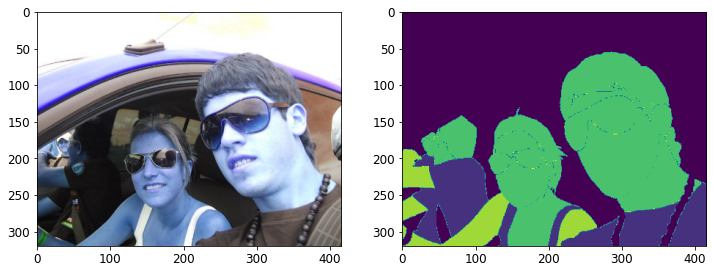

In [100]:
for x, y in train_data_3.take(1):

  index = 8

  image = x[index]

  mask = np.argmax(y[index], axis=-1)
  mask = mask.astype(np.float32)

  fig = plt.figure(figsize=(12, 8))

  fig.add_subplot(1, 2, 1)
  plt.imshow(image)

  fig.add_subplot(1, 2, 2)
  plt.imshow(mask)

  print(image.shape, y[index].shape, mask.shape)

  print(y[index][-4][1])

  print(np.amin(mask), np.amax(mask))

  print(set(mask.flatten()))

  break

In [101]:
IMG_HEIGHT, IMG_WIDTH, N_CHANNELS, N_CLASSES, BATCH_SIZE_PARSING

(320, 416, 3, 8, 32)

In [102]:
# UNET Model

from tensorflow.keras.layers import Input, Concatenate, Conv2DTranspose, MaxPool2D, Activation, BatchNormalization, Conv2D 

def conv_block(input, n_filter):

  x = Conv2D(filters = n_filter, kernel_size = 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters = n_filter, kernel_size = 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def encoder_block(input, n_filter):

  s = conv_block(input, n_filter)
  p = MaxPool2D(pool_size=(2, 2))(s)

  return s, p

def decoder_block(input, skip_input, n_filter):

  # Conv2DTranspose's main purpose is to increase dimensions (by factor 2 as stride = 2),
  # but it also reduces filters by a factor of 2

  # (None, 32, 32, 1024)
  x = Conv2DTranspose(filters = n_filter, kernel_size = 2, strides=2, padding='same')(input)
  
  # x:  (None, 64, 64, 512)
  # s:  (None, 64, 64, 512)
  x = Concatenate()([x, skip_input])

  # (None, 64, 64, 1024)
  x = conv_block(x, n_filter)

  # (None, 64, 64, 512)
  return x


def build_unet_model(input_shape = (512, 512, 3), n_classes = 20):
  # exact mean input shape
  # input = Input(shape = (378, 459, 3))

  # closest to mean input shape
  # input = Input(shape = (400, 480, 3))

  # also working input
  # input = Input(shape = (320, 416, 3))

  # paper's input shape
  # input = Input(shape = (512, 512, 3))

  input = Input(shape = input_shape)

  # encoding
  s1, p1 = encoder_block(input, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  # bridging
  b1 = conv_block(p4, 1024)

  # decoding
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  # every filter represents a segmented object
  # softmax activation is used beacuse we will be doing multi class classification on every pixel
  output_layer = Conv2D(filters = n_classes, kernel_size = 1, padding='same')(d4)
  output = Activation('softmax', dtype=tf.float32)(output_layer)

  model_parsing_0 = tf.keras.Model(inputs=input, outputs=output, name="human_parsing_model")

  print(model_parsing_0.input), print(model_parsing_0.output)

  return model_parsing_0

In [139]:
%%time

INITIAL_LR = 1e-3
MIN_LR = 1e-6
LR_REDUCTION_FACTOR = 0.1
LR_REUCTION_PATIENCE = 2

EARLY_STOPPING_PATIENCE = 2

EPOCHS = 1
VERBOSE = 2
# BATCH_SIZE_PARSING = 16 # defined as global parameter for human parsing model

# These file names refer to names by which model weights files will be saved or loaded: model_parsing_[model_number]_[saved_file_number]
WEIGHT_FILE_NAME = 'model_parsing_4_0.h5'
MODEL_FILE_NAME = 'model_parsing_4_1.h5'

model_parsing_4 = build_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), n_classes=N_CLASSES)

if run_model_parsing_4:

  model_parsing_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(INITIAL_LR), metrics=['accuracy'])

  callbacks = [
      ModelCheckpoint(os.path.join(saved_models_path, WEIGHT_FILE_NAME), save_best_only=True, save_weights_only=True),
      ReduceLROnPlateau(monitor='val_loss', factor=LR_REDUCTION_FACTOR, patience=LR_REUCTION_PATIENCE, min_lr=MIN_LR),
      EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE),
  ]

  model_parsing_4.fit(train_data_3, steps_per_epoch=len(train_data_3),
                      validation_data=valid_data_3, validation_steps=len(valid_data_3),
                      epochs=EPOCHS, verbose=VERBOSE, batch_size=BATCH_SIZE_PARSING, callbacks=callbacks)
  
  model_parsing_4.save(os.path.join(saved_models_path, MODEL_FILE_NAME))

else:

  # currently we are using saved model as model weight file
  model_parsing_4 = load_model(os.path.join(saved_models_path, MODEL_FILE_NAME))
  # model_parsing_4.load_weights(os.path.join(saved_models_path, WEIGHT_FILE_NAME))

model_parsing_4.summary()

# visualize a plot of model
# tf.keras.utils.plot_model(model_parsing_0, show_shapes=True,)

KerasTensor(type_spec=TensorSpec(shape=(None, 320, 416, 3), dtype=tf.float32, name='input_15'), name='input_15', description="created by layer 'input_15'")
KerasTensor(type_spec=TensorSpec(shape=(None, 320, 416, 8), dtype=tf.float32, name=None), name='activation_217/Softmax:0', description="created by layer 'activation_217'")
Model: "human_parsing_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 320, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 320, 416, 64  1792        ['input_4[0][0]']                
                                )                

In [140]:
def calculate_score_for_human_parsing_pred(pred_mask, true_mask, n_classes):

  labels = [i for i in range(n_classes)]

  true_mask = true_mask.flatten()
  pred_mask = pred_mask.flatten()

  f1_score_pred = f1_score(true_mask, pred_mask, labels=labels, average=None, zero_division=0)

  return {'f1_score': f1_score_pred}

In [141]:
def pred_human_parsing(image_path, mask_path, model):

  image, _, _, mask_stack = process_image_and_mask(image_path, mask_path)

  # visualize_process_image_and_mask(image, mask_stack)

  # make image ready for prediction, we are doing this because for prediciton our data must be inside an array
  image = np.expand_dims(image, axis=0)

  # make mask ready for prediction, this will convery on-hot encoded mask back to grey scale image with values 0-19
  mask_onehot = np.argmax(mask_stack, axis=-1)
  mask_onehot = mask_onehot.astype(np.int32)

  true_mask = mask_onehot

  # make prediction and convert one-hot encoded result to image grey scale 0-19
  pred_mask = model.predict(image, verbose=0)[0]
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask.astype(np.float32)

  return pred_mask, true_mask

(320, 416, 8)
f1 =  0.03149425813790283


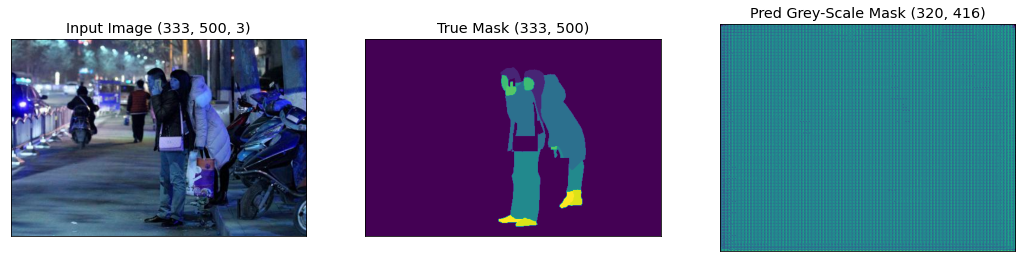

In [146]:
def plot_and_predict_model(class_labels, model):

  random_index = randrange(len(test_x)-1)

  # image_path, mask_path = get_img_and_label_by_index(vton_test_dir, 16)

  image_path = test_x[random_index]
  mask_path = test_y[random_index]

  # predicting the results
  pred_mask, true_mask = pred_human_parsing(image_path, mask_path, model)


  # calculating prediction scores 
  score = calculate_score_for_human_parsing_pred(pred_mask, true_mask, len(class_labels))

  f1_score_pred = score['f1_score']
  # remove zeros
  f1_score_pred = f1_score_pred[f1_score_pred != 0]
  print('f1 = ', np.mean(f1_score_pred, axis=0))


  # ploting the results
  fig = plt.figure(figsize=(18, 12))

  plt.rc('font', size=12) 


  ax1  = fig.add_subplot(1, 3, 1,)
  visual_x = cv2.imread(image_path)
  ax1.imshow(visual_x)
  ax1.set_title('Input Image %s' % str(visual_x.shape))

  plt.xticks([])
  plt.yticks([])


  ax2 = fig.add_subplot(1, 3, 2,)
  true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  ax2.imshow(true_mask)
  ax2.set_title('True Mask %s' % str(true_mask.shape))

  plt.xticks([])
  plt.yticks([])


  ax3 = fig.add_subplot(1, 3, 3,)
  ax3.imshow(pred_mask)
  ax3.set_title('Pred Grey-Scale Mask %s' % str(pred_mask.shape))

  plt.xticks([])
  plt.yticks([])


plot_and_predict_model(merged_class_labels, model_parsing_4)